In [1]:
import os.path
import sys
sys.path.append('/home/galm/software/django/tmv/BasicBrowser')
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
import scoping
from utils.text import *

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC

import pandas as pd
import numpy as np

import pickle
import scipy.sparse

import matplotlib.pyplot as plt

## Load the labelled data

In [2]:
seen_df = pd.read_csv('../data/0_labelled_documents.csv')

df = (seen_df
      .sort_values('id')
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
)

print(df.shape)

seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index
new_index = df[(df['seen']==1) & (df['ar5']==0)].index
rel_index = df[df['relevant']==1].index
r_index = df[df["random_sample"]==1].index
physical_index = df[df['physical_tags']==1].index

(2223, 242)


## The relevant value is evenly distributed

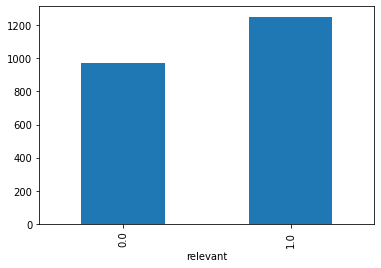

In [3]:
seen_df.groupby('relevant').size().plot.bar()

In [4]:
revectorize = True

X_exists = os.path.isfile(f'../data/X_{seen_df.shape[0]}.npz')

if revectorize is True or X_exists is False:
    print("running vectorisation again")
    vec = TfidfVectorizer(
        ngram_range=(1,2),
        min_df=10, max_df=0.8, strip_accents='unicode', 
        max_features=20000,
        tokenizer=snowball_stemmer()
    )

    X = vec.fit_transform(df['content'].astype("str"))   
    with open (f'../data/vec_{seen_df.shape[0]}.pickle','wb') as f:
        pickle.dump(vec, f)
    import scipy.sparse
    scipy.sparse.save_npz(f'../data/X_{seen_df.shape[0]}.npz', X)
else:
    print("loading feature matrix")
    with open (f'../data/vec_{seen_df.shape[0]}.pickle','rb') as f:
        vec = pickle.load(f)
        X = scipy.sparse.load_npz(f'../data/X_{seen_df.shape[0]}.npz')
        
X.shape

running vectorisation again


(2223, 7180)

In [5]:
test_X = vec.transform(df.loc[df['id']==38721,'content']).todense()
idx = np.ravel(np.argsort(test_X))[-15:]
test_X[:,idx]

matrix([[0.10636919, 0.11798667, 0.12108515, 0.13651566, 0.13669155,
         0.14522799, 0.14909978, 0.16441988, 0.16874382, 0.19380085,
         0.22615919, 0.22857531, 0.23972783, 0.29783468, 0.30121437]])

In [6]:
vocab = np.array(vec.get_feature_names())
vocab[idx]

array(['led', 'plant', 'warm', 'winter', 'continu warm', 'stepp',
       'grow season', 'delay', 'grow', 'veget', 'phenolog', 'the grow',
       'advanc', 'spring phenolog', 'spring'], dtype='<U23')

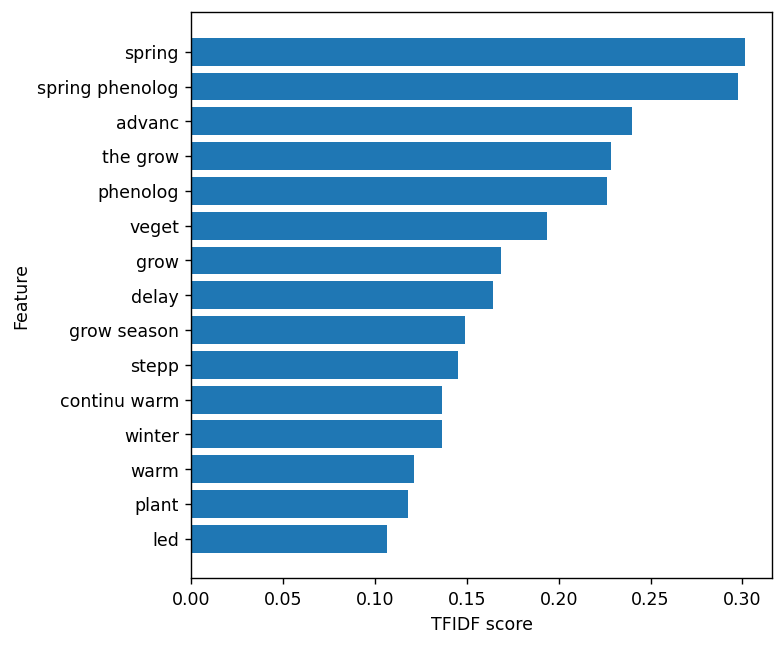

In [7]:
fig, ax = plt.subplots(dpi=125, figsize=(6,6))
bar_idx =np.arange(idx.size)
ax.barh(bar_idx, np.ravel(test_X[:,idx]))
ax.set_yticks(bar_idx)
ax.set_yticklabels(vocab[idx])

ax.set_ylabel('Feature')
ax.set_xlabel('TFIDF score')

plt.savefig('../presentation/images/example_doc_tfidf.pdf', bbox_inches="tight")

In [26]:
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier


y = df['relevant']


from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

clf_models = [
    {
        'title': 'SVM rbf 10', 
        'model': SVC(kernel='rbf',class_weight='balanced',probability=True, C=10)
    },
]

clf_models, df = lu.cross_validate_models(X, y, clf_models, seen_index, n_splits=10, df = df)

1
2
3
4
5
6
7
8
9
10


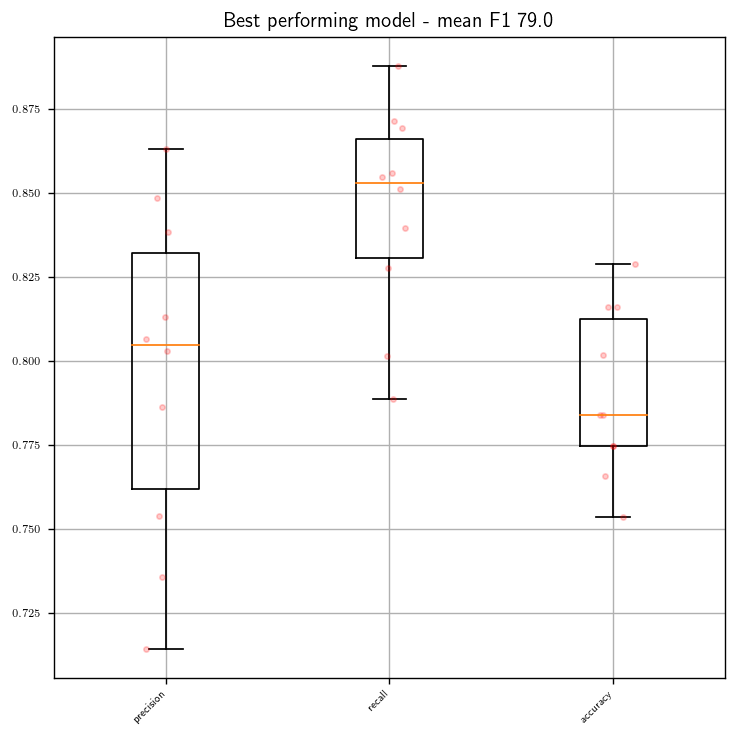

In [27]:
from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

model = clf_models[0]

fig, axs = plt.subplots(1, 1,dpi=125,figsize=(6,6),sharey=True)              
lu.plot_model_output([model],  ['p','r','e'], fig, [axs])
axs.set_xticklabels(["precision","recall","accuracy"])
    
f1 = np.mean(model['e'])
ma = np.mean(model['e'])
mauc = np.mean(model['auc'])
axs.set_title(f"Best performing model - mean F1 {f1:.1%}, mean ROC/AUC: {mauc:.1%}")
fig.tight_layout()
plt.savefig(f'../plots/prediction_models/0_relevance_best_performing.pdf',bbox_inches="tight")
plt.show()

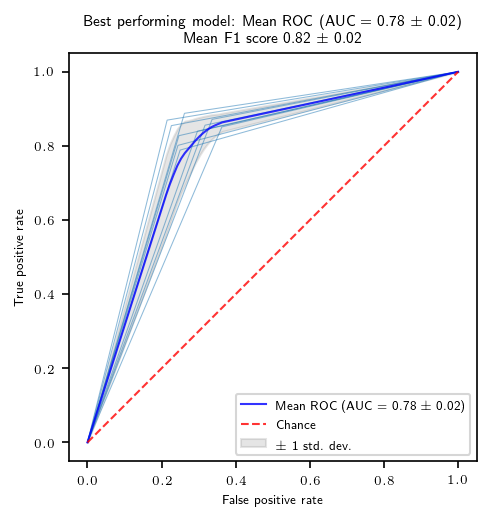

In [37]:
from sklearn.metrics import plot_roc_curve, auc
from scipy import interp
fig, ax = plt.subplots(dpi=150, figsize=(3.6,3.6))

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "axes.labelsize": 7
})

model = clf_models[0]

mean_fpr = np.linspace(0, 1, 100)
mean_auc = np.mean(model['auc'])
std_auc = np.std(model['auc'])

mean_f1 = np.mean(model['f1'])
std_f1 = np.std(model['f1'])

tprs = []
for i in range(len(model['i'])):
    viz = ax.plot(
        model[f'fpr'][i],
        model[f'tpr'][i],
        lw=0.5,
        alpha=0.5,
        color=f"C0"
    )

    interp_tpr = interp(mean_fpr, model[f'fpr'][i], model[f'tpr'][i])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
label = r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc)
ax.plot(mean_fpr, mean_tpr, color='b',
label=label,
lw=1, alpha=.8)


std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')


ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r',
    label='Chance', alpha=.8)

ax.legend(fontsize=6)
ax.set_aspect("equal")

f1_label = r'%0.2f $\pm$ %0.2f' % (mean_f1, std_f1)

ax.set_title(f"Best performing model: {label}\n Mean F1 score {f1_label}", fontsize=7)

ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")

plt.savefig('../figures/si_figure_1.pdf', bbox_inches="tight")
plt.savefig('../figures/si_figure_1.png', bbox_inches="tight")

Text(0.5, 1.0, 'SVM rbf 10')

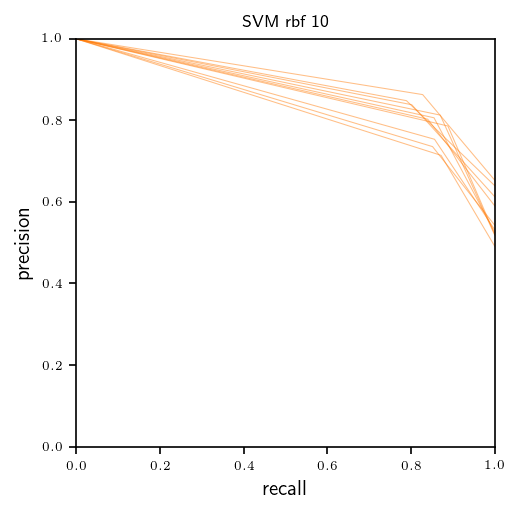

In [31]:
fig, ax = plt.subplots(dpi=150, figsize=(3.6,3.6))

mean_fpr = np.linspace(0, 1, 100)
mean_auc = np.mean(model[f'auc'])
std_auc = np.std(model[f'auc'])
tprs = []
for i in range(len(model['i'])):
    viz = ax.plot(
        model[f'rec'][i],
        model[f'prec'][i],
        lw=0.5,
        alpha=0.5,
        color=f"C1"
    )
ax.set_ylabel('precision')
ax.set_ylim((0,1))
ax.set_xlim((0,1))
ax.set_xlabel('recall')
ax.set_title(model['title'],fontsize=8)

In [23]:
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
import random

y = df['relevant']

print(len(r_index))

test_set = random.sample(set(r_index), 250)


from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

clf_models_random = [
    {
        'title': 'SVM rbf 10', 
        'model': SVC(kernel='rbf',class_weight='balanced',probability=True, C=10)
    },
]

clf_models_random, df_random = lu.cross_validate_models(
    X, y, clf_models, 
    seen_index.difference(test_set), 
    test_index=test_set,
    n_splits=10, df = df
)

451
1
2
3
4
5
6
7
8
9
10


Text(0.5, 1.0, 'Best performing model: Mean ROC (AUC = 0.71 $\\pm$ 0.01)\n Mean F1 score 0.51 $\\pm$ 0.02')

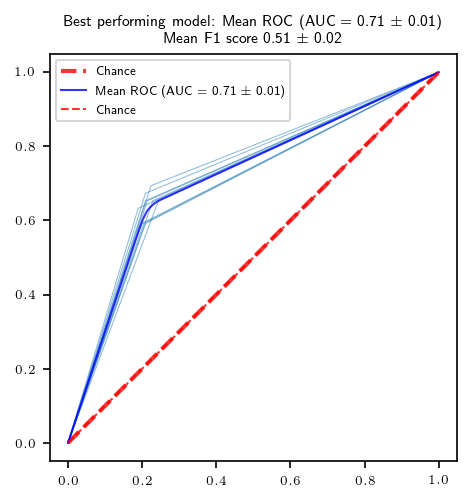

In [24]:
from sklearn.metrics import plot_roc_curve, auc
from scipy import interp
fig, ax = plt.subplots(dpi=150, figsize=(3.6,3.6))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "xtick.labelsize": 6,
    "ytick.labelsize": 6
})

model = clf_models_random[0]

mean_fpr = np.linspace(0, 1, 100)
mean_auc = np.mean(model['auc'])
std_auc = np.std(model['auc'])

mean_f1 = np.mean(model['f1'])
std_f1 = np.std(model['f1'])

tprs = []
for i in range(len(model['i'])):
    viz = ax.plot(
        model[f'fpr'][i],
        model[f'tpr'][i],
        lw=0.5,
        alpha=0.5,
        color=f"C0"
    )

    interp_tpr = interp(mean_fpr, model[f'fpr'][i], model[f'tpr'][i])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
label = r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc)
ax.plot(mean_fpr, mean_tpr, color='b',
label=label,
lw=1, alpha=.8)

ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r',
    label='Chance', alpha=.8)

ax.legend(fontsize=6)
ax.set_aspect("equal")

f1_label = r'%0.2f $\pm$ %0.2f' % (mean_f1, std_f1)

ax.set_title(f"Best performing model: {label}\n Mean F1 score {f1_label}", fontsize=7)

#plt.savefig('../figures/si_figure_1.pdf')